In [1]:
import numpy as np
import pandas as pd
import math
from datascience import *

import matplotlib
matplotlib.use('Agg', warn=False)
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)


**Question 1.1.** What additional information will we need before we can check for that association?

**Explanation:** We need to now whether respectives states implememted the death penality or not

In [2]:
murder_rates = Table.read_table('crime_rates.csv').select(['State', 'Year', 'Population', 'Murder Rate'])
murder_rates.set_format(2, NumberFormatter)

State,Year,Population,Murder Rate
Alaska,1960,"226,167",10.2
Alaska,1961,"234,000",11.5
Alaska,1962,"246,000",4.5
Alaska,1963,"248,000",6.5
Alaska,1964,"250,000",10.4
Alaska,1965,"253,000",6.3
Alaska,1966,"272,000",12.9
Alaska,1967,"272,000",9.6
Alaska,1968,"277,000",10.5
Alaska,1969,"282,000",10.6


**Question 1.2.** Draw a line plot with years on the horizontal axis and murder rates on the vertical axis. Include two lines: one for Alaska murder rates and one for Minnesota murder rates. Create this plot using a single call: ak mn.plot(’Year’).

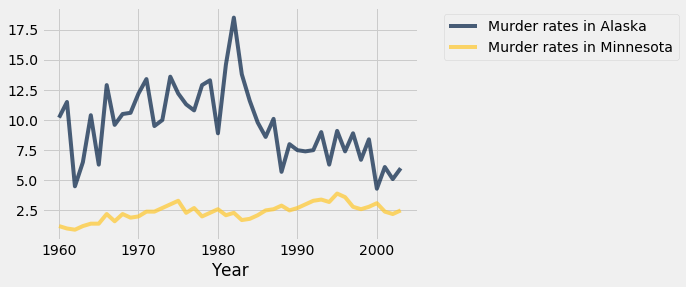

In [3]:
ak = murder_rates.where('State', 'Alaska').drop(['State', 'Population']).relabeled(1, 'Murder rates in Alaska')
mn = murder_rates.where('State', 'Minnesota').drop(['State', 'Population']).relabeled(1, 'Murder rates in Minnesota')
ak_mn = ak.join("Year",mn)
ak_mn.plot('Year')

**Question 1.3.** Implement the function most murderous, which takes a year (an integer) as its argument.
It does two things:
    1.	It draws a horizontal bar chart of the 5 states that had the highest murder rate in that year.
    2.	It returns an array of the names of these states in order of increasing murder rate.

array(['California', 'Mississippi', 'Texas', 'New York', 'Louisiana'],
      dtype='<U14')

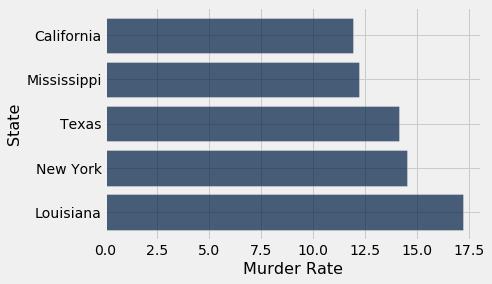

In [4]:
def most_murderous(year):
    most = murder_rates.where('Year', year).sort('Murder Rate',descending = True).take(np.arange(5)).sort('Murder Rate')
    most.barh('State', 'Murder Rate')
    return most.column('State')

most_murderous(1990)

**Question 1.4.** How many more people were murdered in California in 1988 than in 1975? Assign ca_change to the answer.

In [5]:
ca = murder_rates.where('State', 'California')
ca_change = (ca.where('Year',1988).column(3).item(0)*ca.where('Year',1988).column(2).item(0)-ca.where('Year',1975).column(3).item(0)*ca.where('Year',1975).column(2).item(0))
np.round(ca_change)

72623197.0

**Question 2.1.** Implement the function two_year_changes that takes a list of murder rates for a state, ordered by increasing year. For all two-year periods (e.g., from 1960 to 1962), it computes and returns the number of increases minus the number of decreases.

For example, the rates r = [10, 7, 12, 9, 13, 9, 11] contain three increases (10 to 12, 7 to 9, and 12 to 13), one decrease (13 to 11), and one change that is neither an increase or decrease (9 to 9). Therefore, two_year_changes(r) would return 2, the difference between three increases and 1 decrease.

In [6]:
def diff_n(values, n):
    return np.array(values)[n:] - np.array(values)[:-n]

diff_n([1, 10, 100, 1000, 10000], 2)

array([  99,  990, 9900])

In [7]:
def two_year_changes(rates):
    #"Return the number of increases minus the number of decreases after two years."
    return np.count_nonzero(diff_n(rates,2)>0)-np.count_nonzero(diff_n(rates,2)<0)

print('Alaska:',    two_year_changes(ak.column('Murder rates in Alaska')))
print('Minnesota:', two_year_changes(mn.column('Murder rates in Minnesota')))

Alaska: -5
Minnesota: 6


**Question 2.2.** Assign changes by state to a table with one row per state that has two columns: the State name and the Murder Rate two year changes statistic computed across all years in our data set for that state.

In [8]:
states = murder_rates.sort('State',distinct= True).column(0)
change = make_array()
for i in np.arange(len(states)):
    c = two_year_changes(murder_rates.where('State',states[i]).column(3))
    change = np.append(change,c)
changes_by_state = Table().with_columns('State',states,'Murder Rate two_year_changes',change)
changes_by_state

State,Murder Rate two_year_changes
Alabama,-6
Alaska,-5
Arizona,1
Arkansas,-1
California,17
Colorado,-4
Connecticut,4
Delaware,-3
Florida,-6
Georgia,-3


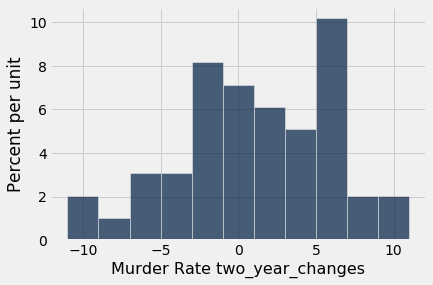

In [9]:
changes_by_state.hist(1, bins=np.arange(-11, 12, 2))

**Question 2.3.** Assign total changes to the total increases minus the total decreases for all two-year periods and all states in our data set.

In [10]:
total_changes = sum(change)
print('Total increases minus total decreases, across all states and years:', total_changes)

Total increases minus total decreases, across all states and years: 45.0


**Question 2.4.** Set `num_changes` to the number of different two-year periods in the entire data set that could result in a change of a state's murder rate. Include both those periods where a change occurred and the periods where a state's rate happened to stay the same.

In [11]:
pds = make_array()
for i in np.arange(len(states)):
    pd = murder_rates.where('State',states[i]).num_rows-2
    pds = np.append(pds,pd)
num_changes = sum(pds) 
num_changes

2100.0

**Question 2.5.** Given these null and alternative hypotheses, define a good test statistic.
Important requirements for your test statistic: Choose a test statistic for which large positive values are evidence in favor of the alternative hypothesis, and other values are evidence in favor of the null hypothesis. Your test statistic should depend only on whether murder rates increased or decreased, not on the size of any change.

In [12]:
uniform = Table(['Change', 'Chance']).with_rows([['Increase', 0.5], ['Decrease', 0.5]])
uniform.sample_from_distribution('Chance', 100)

Change,Chance,Chance sample
Increase,0.5,56
Decrease,0.5,44


**Question 2.6.** Complete the simulation below, which samples `num_changes` increases/decrease at random many times in order to form an empirical distribution of the difference between increases and decreases under the null hypothesis. The `uniform_samples` table should contain one row for each repetition that contains the difference between increases and decreases.

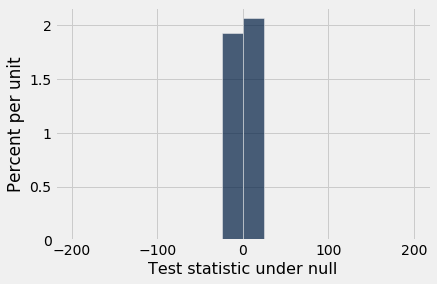

In [13]:
def simulate_under_null(num_chances_to_change):
    return uniform.sample_from_distribution('Chance', 100).column(2).item(0)-uniform.sample_from_distribution('Chance', 100).column(2).item(1)

uniform_samples = make_array()

for i in np.arange(5000):
    uniform_samples = np.append(uniform_samples, simulate_under_null(num_changes))
Table().with_column('Test statistic under null', uniform_samples).hist(0, bins=np.arange(-200, 201, 25))

**Question 2.7.** Looking at this histogram, draw a conclusion about whether murder rates basically increase as often as they decrease.

**Explanation:** The distribution is centered around 0 strecting out the positive values because the statistic was calculated as an absolute value, which suggests that murder rates basically increase as often as they decrease with minor variation due to chance

In [14]:
which_side = "Right"
if np.count_nonzero(uniform_samples>0)-np.count_nonzero(uniform_samples<0)>0:
    reject_null = True
else:
    reject_null = False
reject_null

False

**Question 3.1.** Describe this investigation in terms of an experiment. What population are we studying? What is the control group? What is the treatment group? What outcome are we measuring?

**Population:** The states which are in United States
**Control Group:** States without the death penalty in force during given years
**Treatment Group:** States with the death penalty in force during given years
**Outcome:** Increase or decrease in murder rate of a state during given years

**Question 3.2.** We want to know whether the death penalty causes a change in the murder rate. Why is it not sufficient to compare murder rates in places and times when the death penalty was in force with places and times when it wasn't?

**Explanation:**
There might be other factors other than whether death penalty was in force that affects the change in murder rate.

**Question 3.3.** Assign death_penalty_murder_rates to a table with the same columns and data as murder_rates, but that has only the rows for states that had the death penalty in 1971.

In [15]:
non_death_penalty_states = make_array('Alaska', 'Hawaii', 'Maine', 'Michigan', 'Wisconsin', 'Minnesota')
def had_death_penalty_in_1971(state):
    return state not in non_death_penalty_states

states = murder_rates.group('State').select('State')
death_penalty = states.with_column('Death Penalty', states.apply(had_death_penalty_in_1971, 0))


states = death_penalty.where('Death Penalty', True).column(0)
death_penalty_murder_rates = murder_rates.where('State',are.contained_in(states))
death_penalty_murder_rates


State,Year,Population,Murder Rate
Alabama,1960,"3,266,740",12.4
Alabama,1961,"3,302,000",12.9
Alabama,1962,"3,358,000",9.4
Alabama,1963,"3,347,000",10.2
Alabama,1964,"3,407,000",9.3
Alabama,1965,"3,462,000",11.4
Alabama,1966,"3,517,000",10.9
Alabama,1967,"3,540,000",11.7
Alabama,1968,"3,566,000",11.8
Alabama,1969,"3,531,000",13.7


**Question 3.4.** Assign changes_72 to the value of the test statistic for the years 1971 to 1973 and the states in death penalty murder rates.

In [16]:
t = death_penalty_murder_rates.where('Year', are.between(1971,1974))
states = t.sort('State', distinct = True).column(0)
stats = make_array()
for i in np.arange(len(states)):
    s = diff_n(t.where('State',states[i]).column(3), 2)
    stats = np.append(stats,s)
changes_72 = np.count_nonzero(stats>0)- np.count_nonzero(stats<0)
print('Test statistic from 1971 to 1973:', changes_72)

Test statistic from 1971 to 1973: 22


**Question 3.5.** Draw an empirical histogram of the statistic under the null hypothesis by simulating the test statistic 5,000 times

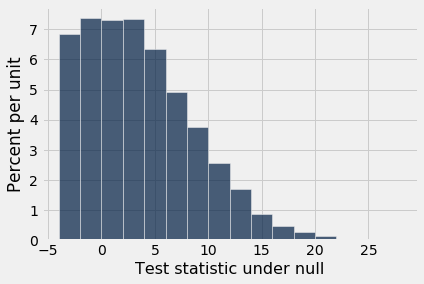

In [17]:
samples = make_array()
for i in np.arange(10000):
    sample = simulate_under_null(len(states))
    samples = np.append(samples, sample)
Table().with_column('Test statistic under null', samples).hist(bins=np.arange(-4, 28+2, 2))

**Question 3.6.** Complete the analysis as follows:
    1.	Compute a P-value.
    2.	Draw a conclusion about the null and alternative hypotheses.
    3.	Describe your findings using simple, non-technical language. Be careful not to claim that the statistical analysis has established more than it really has.

In [18]:
p = np.count_nonzero(samples>=changes_72)/10000
p

0.0009

**Conclusion about the hypotheses:** We accept the alternate hypothesis because the p-value is less than 1%, it is highly statistically significant at the 1% level and we can reject the null hypothesis that each state's murder rate was equally likely to be higher or lower in the treatment period than in the control period and accept the alternative hypothesis.
**Findings:** The statistical analysis shows that change in murder rates is not due to chance and that murder rates are related to whether or not the death penality was instituted.

**Question 4.1.** Implement run test, which takes the following arguments:
    • A table of murder rates for certain states, sorted by state and year like murder rates, and 
    • the year when the analysis starts. (The comparison group is two years later.)
It prints out the observed test statistic and returns the P-value for this statistic under the null hypothesis.

In [19]:
def run_test(rates, start_year):

    states1 = rates.sort('State',distinct = True).column('State')
    end_year = start_year + 2
    year = rates.where('Year',are.between(start_year,end_year+1))
    stats = make_array()
    for i in np.arange(len(states1)):
        s = diff_n(year.where('State',states1[i]).column(3), 2)
        stats = np.append(stats,s)
    observed_test_statistic = np.count_nonzero(stats>0)-np.count_nonzero(stats<0)
    print('Test statistic', start_year, 'to', end_year, ':', observed_test_statistic)
    num_states = rates.group('State').num_rows
    samples = make_array()
    for i in np.arange(5000):
        sample = simulate_under_null(len(states1))
        samples = np.append(samples, sample)
    if observed_test_statistic > 0:
        p = np.count_nonzero(samples>observed_test_statistic)/5000
        return p
    elif observed_test_statistic < 0:
        p = np.count_nonzero(samples<observed_test_statistic)/5000
        return p

run_test(death_penalty_murder_rates, 1971)

Test statistic 1971 to 1973 : 22


0.0006

**Question 4.3.** Now we’ve analyzed states where the death penalty went away and came back, as well as states where the death penalty was outlawed all along. What do you conclude from the results of the tests we have conducted so far? Does all the evidence consistently point toward one conclusion, or is there a contradiction?

Our results point toward the conclusion that the death penalty moratorium increased murder rates, but we have not accounted for time as a confounding factor.

**Question 5.1.** Create a table called average murder rates with 1 row for each year in murder rates.
    It should have 3 columns: 
    • Year, the year, 
    • Death penalty states, the average murder rate of the states that had the death penalty in 1971, and 
    • No death penalty states, the average murder rate of the other states.

In [20]:
years = murder_rates.sort('Year',distinct = True).column('Year')
states = murder_rates.sort('State',distinct= True).column(0)
death = murder_rates.where('State',are.contained_in(states)).group('Year',np.mean).column(3)
no_death = murder_rates.where('State',are.contained_in(non_death_penalty_states)).group('Year',np.mean).column(3)
average_murder_rates = Table().with_columns('Year',years,'Death penalty states',death,'No death penalty states',no_death)
average_murder_rates

Year,Death penalty states,No death penalty states
1960,5.072,3.55
1961,4.646,3.68333
1962,4.342,2.33333
1963,4.39,2.75
1964,4.554,3.4
1965,4.63,3.18333
1966,5.322,4.51667
1967,5.618,3.73333
1968,6.086,4.73333
1969,6.29,4.73333


**Question 5.2.** Describe in one short sentence a high-level takeaway from the line plot below. Are the murder rates in these two groups of states related?

Murder rates seem to rise and fall together with a similar trend across all states, both with and without the death penalty, but those states without the death penalty consistently have a lower murder rate during this time period.


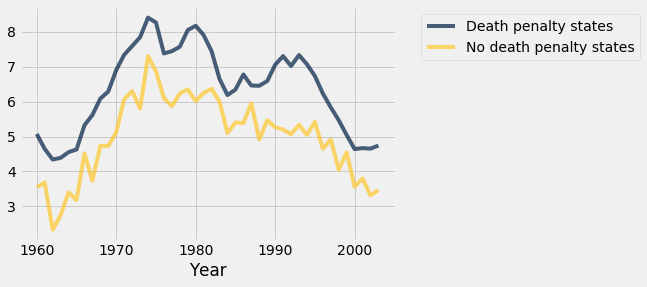

In [21]:
average_murder_rates.plot('Year')

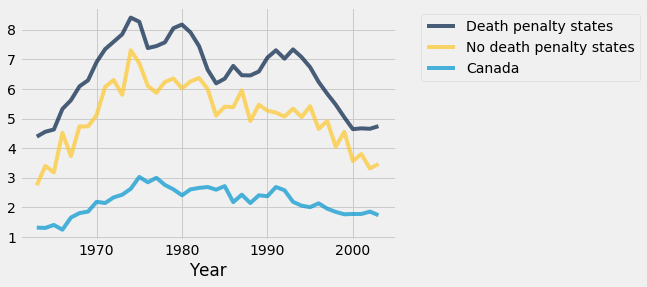

In [22]:
canada = Table.read_table('canada.csv')
murder_rates_with_canada = average_murder_rates.join("Year", canada.select(["Year", "Homicide"]).relabeled("Homicide", "Canada"))
murder_rates_with_canada.plot('Year')

**Question 5.3.** Complete their argument in 2-3 sentences; what features of these plots indicate that the death penalty is not an important factor in determining the murder rate? (If you’re stuck, read the paper.)

Regardless of wether or not there is a death penality instituted or not the murder rates rised and fell at almost the same rate.this shows that the change in murder rates is not dependent on the death penality policy but the external factors.it is also interesting to note that although the US and canada follow different timelines of policy they still the same trends.

**Question 5.5.** What assumption(s) did we make in Parts 1 through 4 of the project that led us to believe that the death penalty deterred murder, when in fact the line plots tell a diﬀerent story?

We have assumed that murder rates rise and fall as a factor of whether or not the death penality was intitutes and failed to consider other factors other than the policy implementation.though we has small p-value and failed to accept the null hypothesis we assumed this was due to the death penality policy, in reality it was due to other factors as seen in line plots.